In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib
from matplotlib import cm, gridspec
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.pipeline import Pipeline
import itertools
from sklearn.utils import resample

### IMPORTANDO DADOS

In [453]:
df = pd.read_csv('dados.banco_credito.csv', sep=',')
df.head()

,cliente_id,renda,score_credito,idade,tempo_conta_anos,num_produtos,saldo_medio,inadimplencia_passada
0,1,4417.395681,557,33,4,3,18164.538186,0
1,2,5772.653252,626,65,5,3,9092.387443,0
2,3,5974.557615,857,46,11,4,15534.569736,0
3,4,2798.082012,436,68,16,1,25563.745589,0
4,5,9924.115693,782,31,9,1,15052.641532,0


### PRÉ PROCESSAMENTO

In [454]:
dados = df.copy()

# Cria faixa etária, mas mantém a idade contínua
bins_3   = [17, 35, 59, 100]
labels_3 = ["Jovem", "Adulto", "Idoso"]
dados["faixa_etaria"] = pd.cut(dados["idade"], bins=bins_3, labels=labels_3)

In [455]:
# Features para clustering
use_cols = ['renda','score_credito','idade','tempo_conta_anos',
            'num_produtos','saldo_medio','inadimplencia_passada','faixa_etaria']
X = dados[use_cols].copy()

### CODIFICAÇÃO DE CATEGORIA

In [456]:
# One-hot apenas da coluna categórica
X = pd.get_dummies(X, columns=['faixa_etaria'], drop_first=False, dtype=int)
X.head()

,renda,score_credito,idade,tempo_conta_anos,num_produtos,saldo_medio,inadimplencia_passada,faixa_etaria_Jovem,faixa_etaria_Adulto,faixa_etaria_Idoso
0,4417.395681,557,33,4,3,18164.538186,0,1,0,0
1,5772.653252,626,65,5,3,9092.387443,0,0,0,1
2,5974.557615,857,46,11,4,15534.569736,0,0,1,0
3,2798.082012,436,68,16,1,25563.745589,0,0,0,1
4,9924.115693,782,31,9,1,15052.641532,0,1,0,0


### ESCOLHA DE K  | ELBOW + SILHOUETTE

In [457]:
RANDOM_STATE = 42
PCA_VAR_THR = 0.85
K_RANGE = range(2, 15)
SCALERS = {'standard': StandardScaler(), 'robust': RobustScaler()}
WHITEN = [False, True]

In [458]:
def n_components_for_threshold(pca):
    csum = np.cumsum(pca.explained_variance_ratio_)
    pcs  = np.argmax(csum >= PCA_VAR_THR) + 1 if (csum >= PCA_VAR_THR).any() else len(csum)
    return max(2, pcs)

In [459]:
results = []
cache_X = {}  # guarda X_transformado por (scaler_name, whiten) p/ reuso

In [460]:
for s_name, scaler in SCALERS.items():
    for w in WHITEN:
        # Fit scaler + PCA
        pipe_pca = Pipeline([('scaler', scaler), ('pca', PCA(whiten=w, random_state=RANDOM_STATE))])
        X_pca    = pipe_pca.fit_transform(X)
        pcs      = n_components_for_threshold(pipe_pca.named_steps['pca'])
        X_final  = X_pca[:, :pcs]
        cache_X[(s_name, w, pcs)] = X_final

        for k in K_RANGE:
            km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=50)
            labels = km.fit_predict(X_final)
            sil = silhouette_score(X_final, labels)
            results.append({'scaler': s_name, 'whiten': w, 'pcs': pcs, 'k': k, 'silhouette': sil})

In [461]:
grid = pd.DataFrame(results).sort_values(['silhouette','k'], ascending=[False,True]).reset_index(drop=True)

In [462]:
best = grid.iloc[0].to_dict()

In [463]:
best_row = grid.iloc[0]
BEST_K = int(best_row['k'])
BEST_SIL = float(best_row['silhouette'])
BEST_PCS = int(best_row['pcs'])
BEST_SCALER = best_row['scaler']
BEST_WHITEN = bool(best_row['whiten'])

In [464]:
# Filtra o grid existente
sel = grid[(grid['scaler'] == BEST_SCALER) &
           (grid['whiten'] == BEST_WHITEN) &
           (grid['pcs'] == BEST_PCS)].copy()

In [465]:
print('Melhor configuração K-Means:', best)

Melhor configuração K-Means: {'scaler': 'standard', 'whiten': False, 'pcs': 7, 'k': 3, 'silhouette': 0.3267016634876417}


In [466]:
Xspace = cache_X[(BEST_SCALER, BEST_WHITEN, BEST_PCS)]

In [467]:
# Se size_max não existir, criamos agora (usando Xspace)
if 'size_max' not in sel.columns:
    size_max_list = []
    for k in sel['k'].tolist():
        km = KMeans(n_clusters=int(k), random_state=RANDOM_STATE, n_init=50)
        labels = km.fit_predict(Xspace)
        counts = np.bincount(labels, minlength=int(k))
        size_max_list.append(int(counts.max()))
    sel['size_max'] = size_max_list

In [468]:
# Mantém ordenado por k para plote bonito
sel = sel.sort_values('k').reset_index(drop=True)

In [469]:
print(f"Melhor configuração -> scaler={BEST_SCALER}, whiten={BEST_WHITEN}, pcs={BEST_PCS}, k={BEST_K}, silhouette={BEST_SIL:.3f}")
sel.head()

Melhor configuração -> scaler=standard, whiten=False, pcs=7, k=3, silhouette=0.327


,scaler,whiten,pcs,k,silhouette,size_max
0,standard,False,7,2,0.265101,636
1,standard,False,7,3,0.326702,470
2,standard,False,7,4,0.323030,405
3,standard,False,7,5,0.309192,405
4,standard,False,7,6,0.252278,300


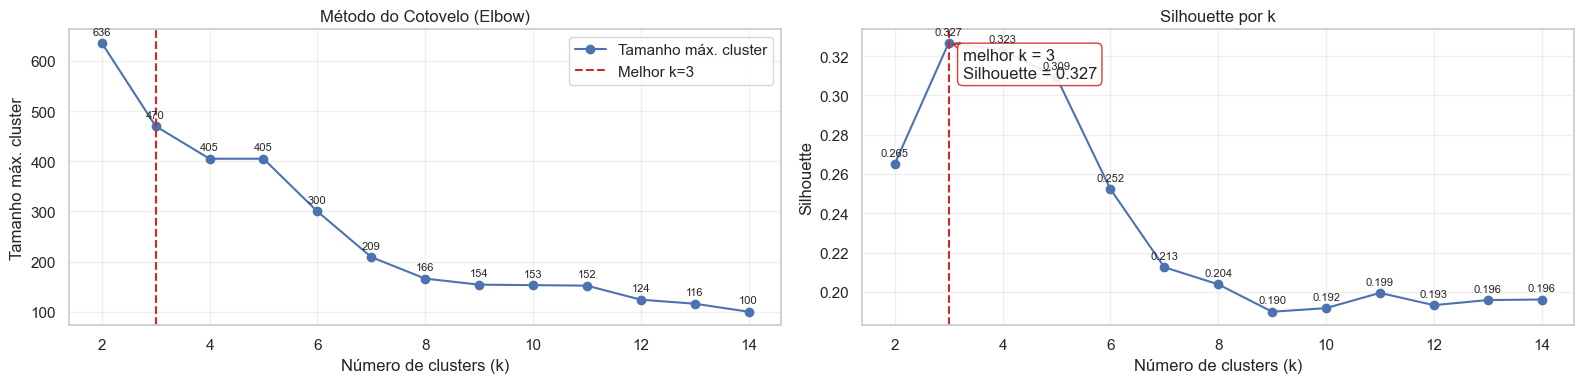

In [484]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# --- Elbow (usando o tamanho máximo de cluster como "proxy" de desbalanceamento) ---
axes[0].plot(sel['k'], sel['size_max'], marker='o', label='Tamanho máx. cluster')
axes[0].axvline(BEST_K, linestyle='--', color='tab:red', label=f"Melhor k={BEST_K}")
axes[0].set_title("Método do Cotovelo (Elbow)")
axes[0].set_xlabel("Número de clusters (k)")
axes[0].set_ylabel("Tamanho máx. cluster")
axes[0].grid(True, alpha=0.3)
axes[0].legend(loc="best")
for x_val, y_val in zip(sel['k'], sel['size_max']):
    axes[0].annotate(f"{y_val:.0f}", (x_val, y_val), textcoords="offset points",
                     xytext=(0, 6), ha='center', fontsize=8)

# --- Silhouette por k ---
axes[1].plot(sel['k'], sel['silhouette'], marker='o')
axes[1].axvline(BEST_K, color='tab:red', linestyle='--', linewidth=1.5)
axes[1].annotate(f"melhor k = {BEST_K}\nSilhouette = {BEST_SIL:.3f}",
                 (BEST_K, BEST_SIL),
                 textcoords="offset points", xytext=(10, -25),
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="tab:red", alpha=0.9),
                 arrowprops=dict(arrowstyle="->", color="tab:red"))
axes[1].set_title("Silhouette por k")
axes[1].set_xlabel("Número de clusters (k)")
axes[1].set_ylabel("Silhouette")
axes[1].grid(True, alpha=0.3)
for x_val, y_val in zip(sel['k'], sel['silhouette']):
    axes[1].annotate(f"{y_val:.3f}", (x_val, y_val), textcoords="offset points",
                     xytext=(0, 6), ha='center', fontsize=8)

plt.tight_layout()
plt.show()


### APLICANDO K-MEANS | BEST K

In [471]:
# [KERNEL] Ajuste final do K-Means no MESMO espaço
km_final = KMeans(n_clusters=BEST_K, random_state=RANDOM_STATE, n_init=50)

In [472]:
labels_km = km_final.fit_predict(Xspace)

In [473]:
# Guarda os cluster atribuídos
df['cluster_kmeans'] = labels_km

In [474]:
# Centróides no espaço escalado:
centroids = km_final.cluster_centers_
centroids

array([[-0.91387004, -1.07682178, -0.05118986, -0.09340507, -0.0375629 ,
        -0.01250214,  0.09895051],
       [-1.75904526,  2.33877784,  0.1265551 ,  0.19687352,  0.03366194,
        -0.00360087, -0.16248626],
       [ 1.98219899,  0.32381625,  0.0083821 ,  0.03082247,  0.03315022,
         0.01778503, -0.05366489]])

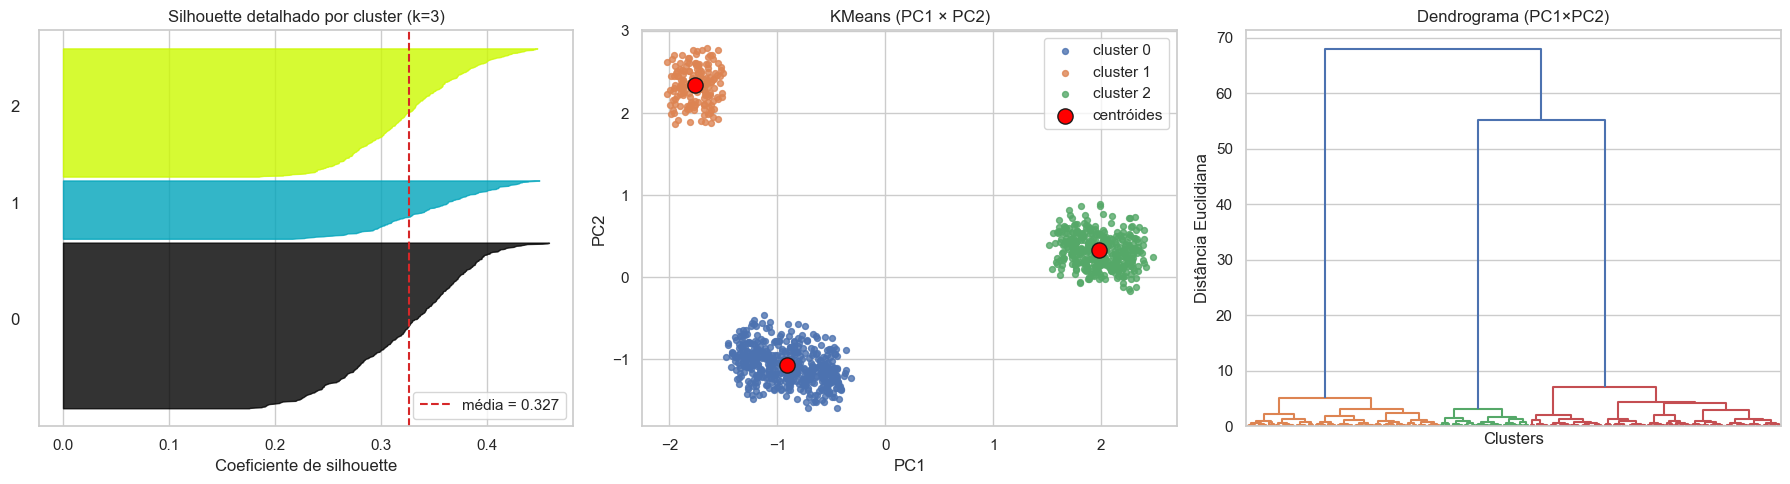

In [475]:
# [KERNEL] Painel K-Means: Silhouette detalhado, Scatter PC1xPC2 com centróides, e Dendrograma

# --- Figura composta ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
ax_sil, ax_scatter, ax_dend = axes

# 3.1) Silhouette detalhado por cluster
sample_sil = silhouette_samples(Xspace, labels_km)
sil_avg = silhouette_score(Xspace, labels_km)
y_lower = 10
for i in range(BEST_K):
    ith = sample_sil[labels_km == i]
    ith.sort()
    size_i = ith.shape[0]
    y_upper = y_lower + size_i
    color = cm.nipy_spectral(float(i) / BEST_K)
    ax_sil.fill_betweenx(np.arange(y_lower, y_upper), 0, ith,
                         facecolor=color, edgecolor=color, alpha=0.8)
    ax_sil.text(-0.05, y_lower + 0.5 * size_i, str(i))
    y_lower = y_upper + 10
ax_sil.axvline(sil_avg, color='tab:red', linestyle='--', label=f"média = {sil_avg:.3f}")
ax_sil.set_title(f"Silhouette detalhado por cluster (k={BEST_K})")
ax_sil.set_xlabel("Coeficiente de silhouette")
ax_sil.set_yticks([])
ax_sil.legend(loc="lower right")

# 3.2) PC1 × PC2 com centróides
pc1, pc2 = Xspace[:, 0], Xspace[:, 1]
for i in range(BEST_K):
    ax_scatter.scatter(pc1[labels_km == i], pc2[labels_km == i],
                       s=18, alpha=0.8, label=f'cluster {i}')
# centróides no mesmo espaço
ax_scatter.scatter(centroids[:, 0], centroids[:, 1],
                   s=120, c='red', marker='o', edgecolor='k', label='centróides')
ax_scatter.set_title("KMeans (PC1 × PC2)")
ax_scatter.set_xlabel("PC1")
ax_scatter.set_ylabel("PC2")
ax_scatter.legend(loc="best")

# 3.3) Dendrograma (usando apenas PC1 e PC2 para legibilidade)
Z = linkage(np.c_[pc1, pc2], method='ward', metric='euclidean')
dendrogram(Z, ax=ax_dend, no_labels=True, color_threshold=None)
ax_dend.set_title("Dendrograma (PC1×PC2)")
ax_dend.set_xlabel("Clusters")
ax_dend.set_ylabel("Distância Euclidiana")

plt.tight_layout()
plt.show()


### APLICANDO GMM

In [476]:
# GMM (testando covariance_types e escolhendo pelo BIC)
cov_types = ['full', 'tied', 'diag', 'spherical']


In [477]:
cand = []

In [478]:
for cov in cov_types:
    g = GaussianMixture(n_components=BEST_K, covariance_type=cov,
                        random_state=RANDOM_STATE, n_init=50)
    g.fit(Xspace)
    cand.append({'cov_type': cov, 'bic': g.bic(Xspace), 'aic': g.aic(Xspace), 'model': g})



In [479]:
gmm_sel = min(cand, key=lambda d: d['bic'])
gmm = gmm_sel['model']
labels_gmm = gmm.predict(Xspace)

In [480]:
# Guarda os cluster atribuídos
df['cluster_gmm']    = labels_gmm

In [481]:
# Matriz de probabilidades (n_linhas × n_clusters)
probs = gmm.predict_proba(Xspace)

# Cria colunas com as probabilidades (4 casas decimais)
for i in range(probs.shape[1]):
    df[f"prob_cluster_{i}"] = np.round(probs[:, i], 4)


In [482]:
df.head()

,cliente_id,renda,score_credito,idade,tempo_conta_anos,num_produtos,saldo_medio,inadimplencia_passada,cluster_kmeans,cluster_gmm,prob_cluster_0,prob_cluster_1,prob_cluster_2
0,1,4417.395681,557,33,4,3,18164.538186,0,2,2,0.0,0.0,1.0
1,2,5772.653252,626,65,5,3,9092.387443,0,1,1,0.0,1.0,0.0
2,3,5974.557615,857,46,11,4,15534.569736,0,0,0,1.0,0.0,0.0
3,4,2798.082012,436,68,16,1,25563.745589,0,1,1,0.0,1.0,0.0
4,5,9924.115693,782,31,9,1,15052.641532,0,2,2,0.0,0.0,1.0


In [483]:
df.to_csv("dados.banco_credito_com_clusters.csv", index=False)